In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()


In [ ]:
parser = argparse.ArgumentParser(description='COVID-19 Detection from X-ray Images')
parser.add_argument('--test_covid_path', type=str, default='/gdrive/My Drive/Research_Documents_completed/Data/Data/test/covid/',
                      help='COVID-19 test samples directory')
parser.add_argument('--test_non_covid_path', type=str, default='/gdrive/My Drive/Research_Documents_completed/Data/Data/test/non/',
                      help='Non-COVID test samples directory')
parser.add_argument('--cut_off_threshold', type=float, default= 0.2, 
                    help='cut-off threshold. Any sample with probability higher than this is considered COVID-19 (default: 0.2)')
parser.add_argument('--batch_size', type=int, default=25, 
                    help='input batch size for training (default: 20)')
parser.add_argument('--num_workers', type=int, default=0, 
                    help='number of workers to train (default: 0)')

import sys
sys.argv=['']
del sys

args = parser.parse_args()


In [ ]:
############### Utility function to find sensitivity and specificity for different cut-off thresholds
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob >= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob < thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = ['Non-Covid','Covid']

## **RESNET18 OBSERVATION**

In [ ]:
############### Test on trained model
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)
resnet18.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Resnet18_completed/resnet18.pt'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


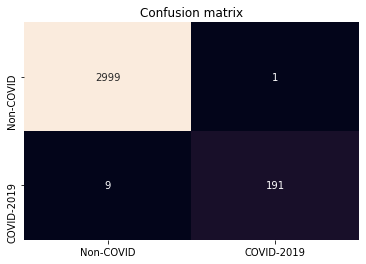

In [ ]:
resnet18.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_r18= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_r18  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_r18= np.zeros([len(test_covid),1])   ##
non_prob_r18   = np.zeros([len(test_non),1])   ##

covid_prob_o_r18 = np.zeros([len(test_covid),1])  ##
non_prob_o_r18   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_r18= image_loader(test_covid[i])
    model_output_r18= resnet18(cur_img_r18)
    cur_pred1_r18 = model_output_r18.max(1, keepdim=True)[1]
    cur_prob_r18 = sm(model_output_r18)
    covid_prob_r18[i,:]= cur_prob_r18.data.numpy()[0,0]
    covid_prob_o_r18[i,:]= cur_prob_r18.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_r18.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_r18= image_loader(test_non[j])
    model_output_r18= resnet18(cur_img_r18)
    cur_pred_r18 = model_output_r18.max(1, keepdim=True)[1]  
    cur_prob_r18 = sm(model_output_r18)
    non_prob_r18[j,:]= cur_prob_r18.data.numpy()[0,0]
    non_prob_o_r18[j,:]= cur_prob_r18.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_r18.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_r18, non_prob_o_r18, thresh)

covid_pred_r18 = np.where( covid_prob_r18  >thresh, 0, 1)
non_pred_r18   = np.where( non_prob_r18  >thresh,   0, 1)

covid_list_r18= [int(covid_pred_r18[i]) for i in range(len(covid_pred_r18))]
covid_count_r18 = [(x, covid_list_r18.count(x)) for x in set(covid_list_r18)]

non_list_r18= [int(non_pred_r18[i]) for i in range(len(non_pred_r18))]
non_count_r18 = [(x, non_list_r18.count(x)) for x in set(non_list_r18)]

y_pred_list_r18= covid_list_r18+non_list_r18
y_test_list_r18= [1 for i in range(len(covid_list_r18))]+[0 for i in range(len(non_list_r18))]

y_pred_r18= np.asarray(y_pred_list_r18, dtype=np.int64) ##
y_test_r18= np.asarray(y_test_list_r18, dtype=np.int64) ##

cnf_matrix_r18 = confusion_matrix(y_test_r18, y_pred_r18)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_r18 = pd.DataFrame(cnf_matrix_r18, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_r18 = sn.heatmap(df_cm_r18, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_r18.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet18_completed/resnet18_confusion_matrix.png') #dpi = 200 ##

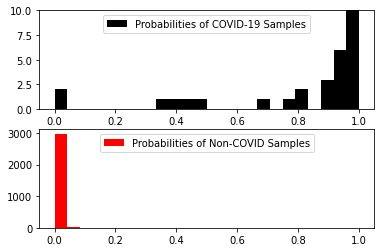

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_r18, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_r18, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet18_completed/resnet18_scores_histogram.png') #dpi = 200


## **RESNET50 OBSERVATION**

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=3e-5)
resnet50.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Resnet50(S)/resnet50.pt'))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Non-Covid
019 Covid predicted label:Covid
020 Covid predicted label:Non-Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Non-Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Non-Covid
030 Covid predicted labe

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid
025 Non-Covid predicted label:Non-Covid


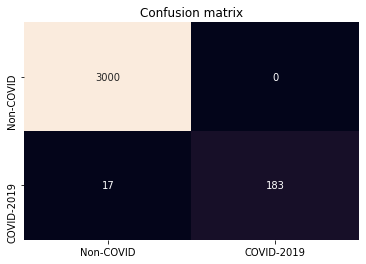

In [ ]:
resnet50.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_r50= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_r50  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_r50= np.zeros([len(test_covid),1])   ##
non_prob_r50   = np.zeros([len(test_non),1])   ##

covid_prob_o_r50 = np.zeros([len(test_covid),1])  ##
non_prob_o_r50   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_r50= image_loader(test_covid[i])
    model_output_r50= resnet50(cur_img_r50)
    cur_pred1_r50 = model_output_r50.max(1, keepdim=True)[1]
    cur_prob_r50 = sm(model_output_r50)
    covid_prob_r50[i,:]= cur_prob_r50.data.numpy()[0,0]
    covid_prob_o_r50[i,:]= cur_prob_r50.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_r50.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_r50= image_loader(test_non[j])
    model_output_r50= resnet50(cur_img_r50)
    cur_pred_r50 = model_output_r50.max(1, keepdim=True)[1]  
    cur_prob_r50 = sm(model_output_r50)
    non_prob_r50[j,:]= cur_prob_r50.data.numpy()[0,0]
    non_prob_o_r50[j,:]= cur_prob_r50.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_r50.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_r50, non_prob_o_r50, thresh)

covid_pred_r50 = np.where( covid_prob_r50  >thresh, 0, 1)
non_pred_r50   = np.where( non_prob_r50  >thresh,   0, 1)

covid_list_r50= [int(covid_pred_r50[i]) for i in range(len(covid_pred_r50))]
covid_count_r50 = [(x, covid_list_r50.count(x)) for x in set(covid_list_r50)]

non_list_r50= [int(non_pred_r50[i]) for i in range(len(non_pred_r50))]
non_count_r50 = [(x, non_list_r50.count(x)) for x in set(non_list_r50)]

y_pred_list_r50= covid_list_r50+non_list_r50
y_test_list_r50= [1 for i in range(len(covid_list_r50))]+[0 for i in range(len(non_list_r50))]

y_pred_r50= np.asarray(y_pred_list_r50, dtype=np.int64) ##
y_test_r50= np.asarray(y_test_list_r50, dtype=np.int64) ##

cnf_matrix_r50 = confusion_matrix(y_test_r50, y_pred_r50)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_r50 = pd.DataFrame(cnf_matrix_r50, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_r50 = sn.heatmap(df_cm_r50, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_r50.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet50(S)/resnet50_confusion_matrix.png') #dpi = 200 ##

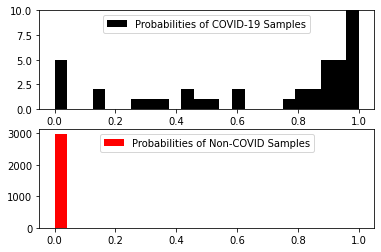

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_r50, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_r50, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet50(S)/resnet50_scores_histogram.png') #dpi = 200

## **RESNET101 OBSERVATION**

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
resnet101.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet101.parameters(), lr=3e-5)
resnet101.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Resnet101(S)/resnet101.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


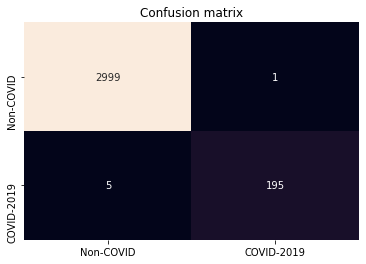

In [ ]:
resnet101.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_r101= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_r101  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_r101= np.zeros([len(test_covid),1])   ##
non_prob_r101   = np.zeros([len(test_non),1])   ##

covid_prob_o_r101 = np.zeros([len(test_covid),1])  ##
non_prob_o_r101   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_r101= image_loader(test_covid[i])
    model_output_r101= resnet101(cur_img_r101)
    cur_pred1_r101 = model_output_r101.max(1, keepdim=True)[1]
    cur_prob_r101 = sm(model_output_r101)
    covid_prob_r101[i,:]= cur_prob_r101.data.numpy()[0,0]
    covid_prob_o_r101[i,:]= cur_prob_r101.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_r101.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_r101= image_loader(test_non[j])
    model_output_r101= resnet101(cur_img_r101)
    cur_pred_r101 = model_output_r101.max(1, keepdim=True)[1]  
    cur_prob_r101 = sm(model_output_r101)
    non_prob_r101[j,:]= cur_prob_r101.data.numpy()[0,0]
    non_prob_o_r101[j,:]= cur_prob_r101.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_r101.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_r101, non_prob_o_r101, thresh)

covid_pred_r101 = np.where( covid_prob_r101  >thresh, 0, 1)
non_pred_r101   = np.where( non_prob_r101  >thresh,   0, 1)

covid_list_r101= [int(covid_pred_r101[i]) for i in range(len(covid_pred_r101))]
covid_count_r101 = [(x, covid_list_r101.count(x)) for x in set(covid_list_r101)]

non_list_r101= [int(non_pred_r101[i]) for i in range(len(non_pred_r101))]
non_count_r101 = [(x, non_list_r101.count(x)) for x in set(non_list_r101)]

y_pred_list_r101= covid_list_r101+non_list_r101
y_test_list_r101= [1 for i in range(len(covid_list_r101))]+[0 for i in range(len(non_list_r101))]

y_pred_r101= np.asarray(y_pred_list_r101, dtype=np.int64) ##
y_test_r101= np.asarray(y_test_list_r101, dtype=np.int64) ##

cnf_matrix_r101 = confusion_matrix(y_test_r101, y_pred_r101)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_r101 = pd.DataFrame(cnf_matrix_r101, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_r101 = sn.heatmap(df_cm_r101, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_r101.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet101(S)/resnet101_confusion_matrix.png') #dpi = 200 ##

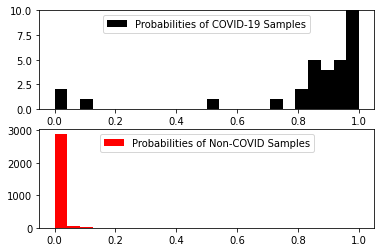

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_r101, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_r101, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet101(S)/resnet101_scores_histogram.png') #dpi = 200

## **RESNET152 OBSERVATION**

In [ ]:
resnet152 = torchvision.models.resnet152(pretrained=True)
resnet152.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152.parameters(), lr=3e-5)
resnet152.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Resnet152(S)/resnet152.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


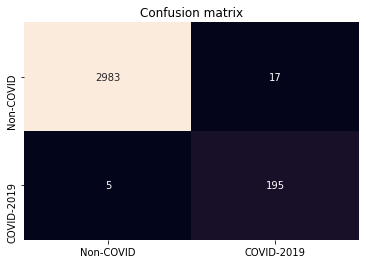

In [ ]:
resnet152.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_r152= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_r152  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_r152= np.zeros([len(test_covid),1])   ##
non_prob_r152   = np.zeros([len(test_non),1])   ##

covid_prob_o_r152 = np.zeros([len(test_covid),1])  ##
non_prob_o_r152   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_r152= image_loader(test_covid[i])
    model_output_r152= resnet152(cur_img_r152)
    cur_pred1_r152 = model_output_r152.max(1, keepdim=True)[1]
    cur_prob_r152 = sm(model_output_r152)
    covid_prob_r152[i,:]= cur_prob_r152.data.numpy()[0,0]
    covid_prob_o_r152[i,:]= cur_prob_r152.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_r152.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_r152= image_loader(test_non[j])
    model_output_r152= resnet152(cur_img_r152)
    cur_pred_r152 = model_output_r152.max(1, keepdim=True)[1]  
    cur_prob_r152 = sm(model_output_r152)
    non_prob_r152[j,:]= cur_prob_r152.data.numpy()[0,0]
    non_prob_o_r152[j,:]= cur_prob_r152.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_r152.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_r152, non_prob_o_r152, thresh)

covid_pred_r152 = np.where( covid_prob_r152  >thresh, 0, 1)
non_pred_r152   = np.where( non_prob_r152  >thresh,   0, 1)

covid_list_r152= [int(covid_pred_r152[i]) for i in range(len(covid_pred_r152))]
covid_count_r152 = [(x, covid_list_r152.count(x)) for x in set(covid_list_r152)]

non_list_r152= [int(non_pred_r152[i]) for i in range(len(non_pred_r152))]
non_count_r152 = [(x, non_list_r152.count(x)) for x in set(non_list_r152)]

y_pred_list_r152= covid_list_r152+non_list_r152
y_test_list_r152= [1 for i in range(len(covid_list_r152))]+[0 for i in range(len(non_list_r152))]

y_pred_r152= np.asarray(y_pred_list_r152, dtype=np.int64) ##
y_test_r152= np.asarray(y_test_list_r152, dtype=np.int64) ##

cnf_matrix_r152 = confusion_matrix(y_test_r152, y_pred_r152)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_r152 = pd.DataFrame(cnf_matrix_r152, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_r152 = sn.heatmap(df_cm_r152, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_r152.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet152(S)/resnet152_confusion_matrix.png') #dpi = 200 ##

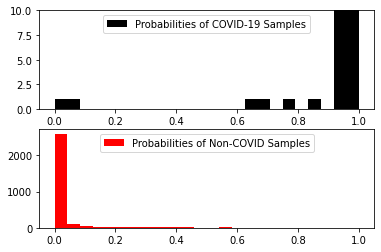

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_r152, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_r152, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Resnet152(S)/resnet152_scores_histogram.png') #dpi = 200

## **Densenet121 OBSERVATION**

In [ ]:
Densenet121 = torchvision.models.densenet121(pretrained=True)
Densenet121.classifier = torch.nn.Linear(in_features=1024, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Densenet121.parameters(), lr=3e-5)
Densenet121.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Densenet121 (B)/Densenet121.pt'))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid
025 Non-Covid predicted label:Non-Covid


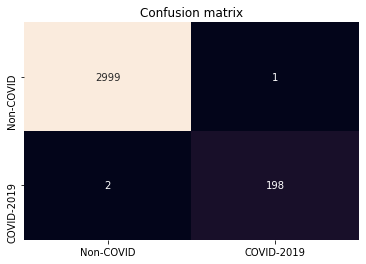

In [ ]:
Densenet121.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_d121= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_d121  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_d121= np.zeros([len(test_covid),1])   ##
non_prob_d121   = np.zeros([len(test_non),1])   ##

covid_prob_o_d121 = np.zeros([len(test_covid),1])  ##
non_prob_o_d121   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_d121= image_loader(test_covid[i])
    model_output_d121= Densenet121(cur_img_d121)
    cur_pred1_d121 = model_output_d121.max(1, keepdim=True)[1]
    cur_prob_d121 = sm(model_output_d121)
    covid_prob_d121[i,:]= cur_prob_d121.data.numpy()[0,0]
    covid_prob_o_d121[i,:]= cur_prob_d121.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_d121.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_d121= image_loader(test_non[j])
    model_output_d121= Densenet121(cur_img_d121)
    cur_pred_d121 = model_output_d121.max(1, keepdim=True)[1]  
    cur_prob_d121 = sm(model_output_d121)
    non_prob_d121[j,:]= cur_prob_d121.data.numpy()[0,0]
    non_prob_o_d121[j,:]= cur_prob_d121.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_d121.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_d121, non_prob_o_d121, thresh)

covid_pred_d121 = np.where( covid_prob_d121  >thresh, 0, 1)
non_pred_d121   = np.where( non_prob_d121  >thresh,   0, 1)

covid_list_d121= [int(covid_pred_d121[i]) for i in range(len(covid_pred_d121))]
covid_count_d121 = [(x, covid_list_d121.count(x)) for x in set(covid_list_d121)]

non_list_d121= [int(non_pred_d121[i]) for i in range(len(non_pred_d121))]
non_count_d121 = [(x, non_list_d121.count(x)) for x in set(non_list_d121)]

y_pred_list_d121= covid_list_d121+non_list_d121
y_test_list_d121= [1 for i in range(len(covid_list_d121))]+[0 for i in range(len(non_list_d121))]

y_pred_d121= np.asarray(y_pred_list_d121, dtype=np.int64) ##
y_test_d121= np.asarray(y_test_list_d121, dtype=np.int64) ##

cnf_matrix_d121 = confusion_matrix(y_test_d121, y_pred_d121)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_d121 = pd.DataFrame(cnf_matrix_d121, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_d121 = sn.heatmap(df_cm_d121, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_d121.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Densenet121 (B)/Densenet121_confusion_matrix.png') #dpi = 200 ##

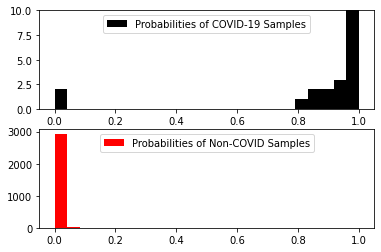

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_d121, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_d121, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Densenet121 (B)/Densenet121_scores_histogram.png') #dpi = 200

## **Densenet161 OBSERVATION**

In [ ]:
Densenet161 = torchvision.models.densenet161(pretrained=True)
Densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Densenet161.parameters(), lr=3e-5)
Densenet161.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Densenet161/d161.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Non-Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


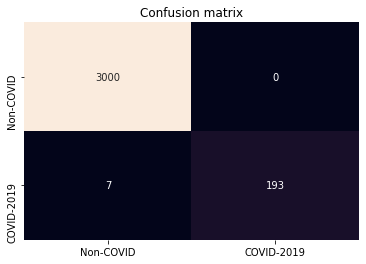

In [ ]:
Densenet161.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_d161= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_d161  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_d161= np.zeros([len(test_covid),1])   ##
non_prob_d161   = np.zeros([len(test_non),1])   ##

covid_prob_o_d161 = np.zeros([len(test_covid),1])  ##
non_prob_o_d161   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_d161= image_loader(test_covid[i])
    model_output_d161= Densenet161(cur_img_d161)
    cur_pred1_d161 = model_output_d161.max(1, keepdim=True)[1]
    cur_prob_d161 = sm(model_output_d161)
    covid_prob_d161[i,:]= cur_prob_d161.data.numpy()[0,0]
    covid_prob_o_d161[i,:]= cur_prob_d161.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_d161.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_d161= image_loader(test_non[j])
    model_output_d161= Densenet161(cur_img_d161)
    cur_pred_d161 = model_output_d161.max(1, keepdim=True)[1]  
    cur_prob_d161 = sm(model_output_d161)
    non_prob_d161[j,:]= cur_prob_d161.data.numpy()[0,0]
    non_prob_o_d161[j,:]= cur_prob_d161.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_d161.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_d161, non_prob_o_d161, thresh)

covid_pred_d161 = np.where( covid_prob_d161  >thresh, 0, 1)
non_pred_d161   = np.where( non_prob_d161  >thresh,   0, 1)

covid_list_d161= [int(covid_pred_d161[i]) for i in range(len(covid_pred_d161))]
covid_count_d161 = [(x, covid_list_d161.count(x)) for x in set(covid_list_d161)]

non_list_d161= [int(non_pred_d161[i]) for i in range(len(non_pred_d161))]
non_count_d161 = [(x, non_list_d161.count(x)) for x in set(non_list_d161)]

y_pred_list_d161= covid_list_d161+non_list_d161
y_test_list_d161= [1 for i in range(len(covid_list_d161))]+[0 for i in range(len(non_list_d161))]

y_pred_d161= np.asarray(y_pred_list_d161, dtype=np.int64) ##
y_test_d161= np.asarray(y_test_list_d161, dtype=np.int64) ##

cnf_matrix_d161 = confusion_matrix(y_test_d161, y_pred_d161)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_d161 = pd.DataFrame(cnf_matrix_d161, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_d161 = sn.heatmap(df_cm_d161, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_d161.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Densenet161/Densenet161_confusion_matrix.png') #dpi = 200 ##

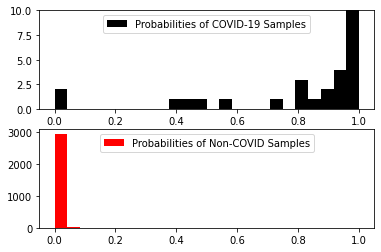

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_d161, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_d161, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Densenet161/Densenet161_scores_histogram.png') #dpi = 200

## **Inception OBSERVATION**

In [ ]:
Inception = torchvision.models.inception_v3(pretrained=True)
Inception.aux_logits=False
Inception.fc = torch.nn.Linear(in_features=2048, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Inception.parameters(), lr=3e-5)
Inception.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Inception (B)/inception.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Non-Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid
025 Non-Covid predicted label:Non-Covid


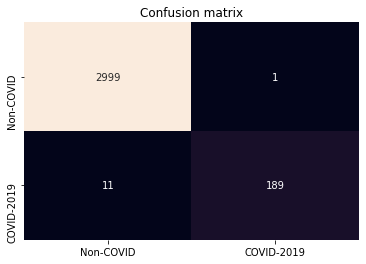

In [ ]:
Inception.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_i= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_i  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_i= np.zeros([len(test_covid),1])   ##
non_prob_i   = np.zeros([len(test_non),1])   ##

covid_prob_o_i = np.zeros([len(test_covid),1])  ##
non_prob_o_i   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_i= image_loader(test_covid[i])
    model_output_i= Inception(cur_img_i)
    cur_pred1_i = model_output_i.max(1, keepdim=True)[1]
    cur_prob_i = sm(model_output_i)
    covid_prob_i[i,:]= cur_prob_i.data.numpy()[0,0]
    covid_prob_o_i[i,:]= cur_prob_i.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_i.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_i= image_loader(test_non[j])
    model_output_i= Inception(cur_img_i)
    cur_pred_i = model_output_i.max(1, keepdim=True)[1]  
    cur_prob_i = sm(model_output_i)
    non_prob_i[j,:]= cur_prob_i.data.numpy()[0,0]
    non_prob_o_i[j,:]= cur_prob_i.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_i.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_i, non_prob_o_i, thresh)

covid_pred_i = np.where( covid_prob_i  >thresh, 0, 1)
non_pred_i   = np.where( non_prob_i  >thresh,   0, 1)

covid_list_i= [int(covid_pred_i[i]) for i in range(len(covid_pred_i))]
covid_count_i = [(x, covid_list_i.count(x)) for x in set(covid_list_i)]

non_list_i= [int(non_pred_i[i]) for i in range(len(non_pred_i))]
non_count_i = [(x, non_list_i.count(x)) for x in set(non_list_i)]

y_pred_list_i= covid_list_i+non_list_i
y_test_list_i= [1 for i in range(len(covid_list_i))]+[0 for i in range(len(non_list_i))]

y_pred_i= np.asarray(y_pred_list_i, dtype=np.int64) ##
y_test_i= np.asarray(y_test_list_i, dtype=np.int64) ##

cnf_matrix_i = confusion_matrix(y_test_i, y_pred_i)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_i = pd.DataFrame(cnf_matrix_i, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_i = sn.heatmap(df_cm_i, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_i.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Inception (B)/Inception_confusion_matrix.png') #dpi = 200 ##

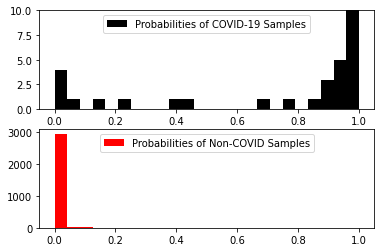

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_i, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_i, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Inception (B)/Inception_scores_histogram.png') #dpi = 200

## **VGG16 OBSERVATION**

In [ ]:
vgg16= torchvision.models.vgg16(pretrained=True)
vgg16.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=3e-5)
vgg16.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/VGG16/vgg16.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


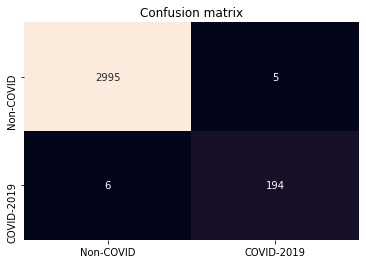

In [ ]:
vgg16.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_v16= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_v16  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_v16= np.zeros([len(test_covid),1])   ##
non_prob_v16   = np.zeros([len(test_non),1])   ##

covid_prob_o_v16 = np.zeros([len(test_covid),1])  ##
non_prob_o_v16   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_v16= image_loader(test_covid[i])
    model_output_v16= vgg16(cur_img_v16)
    cur_pred1_v16 = model_output_v16.max(1, keepdim=True)[1]
    cur_prob_v16 = sm(model_output_v16)
    covid_prob_v16[i,:]= cur_prob_v16.data.numpy()[0,0]
    covid_prob_o_v16[i,:]= cur_prob_v16.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_v16.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_v16= image_loader(test_non[j])
    model_output_v16= vgg16(cur_img_v16)
    cur_pred_v16 = model_output_v16.max(1, keepdim=True)[1]  
    cur_prob_v16 = sm(model_output_v16)
    non_prob_v16[j,:]= cur_prob_v16.data.numpy()[0,0]
    non_prob_o_v16[j,:]= cur_prob_v16.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_v16.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_v16, non_prob_o_v16, thresh)

covid_pred_v16 = np.where( covid_prob_v16  >thresh, 0, 1)
non_pred_v16   = np.where( non_prob_v16  >thresh,   0, 1)

covid_list_v16= [int(covid_pred_v16[i]) for i in range(len(covid_pred_v16))]
covid_count_v16 = [(x, covid_list_v16.count(x)) for x in set(covid_list_v16)]

non_list_v16= [int(non_pred_v16[i]) for i in range(len(non_pred_v16))]
non_count_v16 = [(x, non_list_v16.count(x)) for x in set(non_list_v16)]

y_pred_list_v16= covid_list_v16+non_list_v16
y_test_list_v16= [1 for i in range(len(covid_list_v16))]+[0 for i in range(len(non_list_v16))]

y_pred_v16= np.asarray(y_pred_list_v16, dtype=np.int64) ##
y_test_v16= np.asarray(y_test_list_v16, dtype=np.int64) ##

cnf_matrix_v16 = confusion_matrix(y_test_v16, y_pred_v16)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_v16 = pd.DataFrame(cnf_matrix_v16, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_v16 = sn.heatmap(df_cm_v16, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_v16.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/VGG16/v16_confusion_matrix.png') #dpi = 200 ##

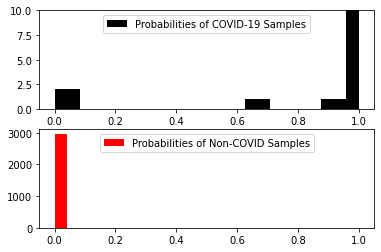

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_v16, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_v16, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/VGG16/v16_scores_histogram.png') #dpi = 200

## **VGG19 OBSERVATION**

In [ ]:
vgg19 = torchvision.models.vgg19(pretrained=True)
vgg19.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=3e-5)
vgg19.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/VGG19/vgg19.pt',map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


<All keys matched successfully>

__main__:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Non-Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 

__main__:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


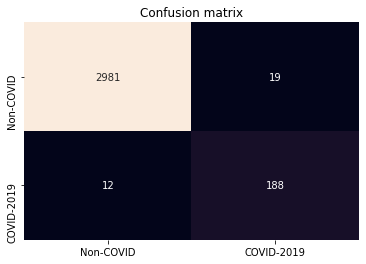

In [ ]:
vgg19.eval() ##
############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_v19= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_v19  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_v19= np.zeros([len(test_covid),1])   ##
non_prob_v19   = np.zeros([len(test_non),1])   ##

covid_prob_o_v19 = np.zeros([len(test_covid),1])  ##
non_prob_o_v19   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_v19= image_loader(test_covid[i])
    model_output_v19= vgg19(cur_img_v19)
    cur_pred1_v19 = model_output_v19.max(1, keepdim=True)[1]
    cur_prob_v19 = sm(model_output_v19)
    covid_prob_v19[i,:]= cur_prob_v19.data.numpy()[0,0]
    covid_prob_o_v19[i,:]= cur_prob_v19.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_v19.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_v19= image_loader(test_non[j])
    model_output_v19= vgg19(cur_img_v19)
    cur_pred_v19 = model_output_v19.max(1, keepdim=True)[1]  
    cur_prob_v19 = sm(model_output_v19)
    non_prob_v19[j,:]= cur_prob_v19.data.numpy()[0,0]
    non_prob_o_v19[j,:]= cur_prob_v19.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_v19.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_v19, non_prob_o_v19, thresh)

covid_pred_v19 = np.where( covid_prob_v19  >thresh, 0, 1)
non_pred_v19   = np.where( non_prob_v19  >thresh,   0, 1)

covid_list_v19= [int(covid_pred_v19[i]) for i in range(len(covid_pred_v19))]
covid_count_v19 = [(x, covid_list_v19.count(x)) for x in set(covid_list_v19)]

non_list_v19= [int(non_pred_v19[i]) for i in range(len(non_pred_v19))]
non_count_v19 = [(x, non_list_v19.count(x)) for x in set(non_list_v19)]

y_pred_list_v19= covid_list_v19+non_list_v19
y_test_list_v19= [1 for i in range(len(covid_list_v19))]+[0 for i in range(len(non_list_v19))]

y_pred_v19= np.asarray(y_pred_list_v19, dtype=np.int64) ##
y_test_v19= np.asarray(y_test_list_v19, dtype=np.int64) ##

cnf_matrix_v19 = confusion_matrix(y_test_v19, y_pred_v19)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_v19 = pd.DataFrame(cnf_matrix_v19, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_v19 = sn.heatmap(df_cm_v19, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_v19.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/VGG19/v19_confusion_matrix.png') #dpi = 200 ##

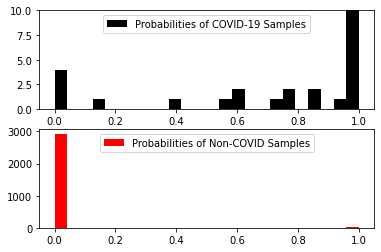

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_v19, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_v19, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/VGG19/v19_scores_histogram.png') #dpi = 200

## **SHhuffleNet OBSERVATION**

In [ ]:
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
shufflenet.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shufflenet.parameters(), lr=3e-5)
shufflenet.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/ShuffleNet/shufflenet.pt'))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


<All keys matched successfully>

__main__:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid
025 Non-Covid predicted label:Non-Covid
026 Non-Covid predicted label:Non-Covid


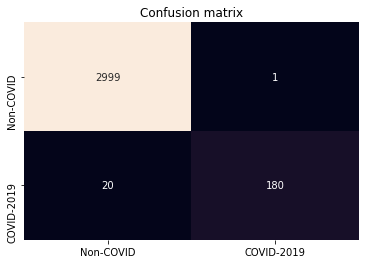

In [ ]:
shufflenet.eval()
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob <= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob >= thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_sh= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_sh  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_sh= np.zeros([len(test_covid),1])   ##
non_prob_sh   = np.zeros([len(test_non),1])   ##

covid_prob_o_sh = np.zeros([len(test_covid),1])  ##
non_prob_o_sh   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_sh= image_loader(test_covid[i])
    model_output_sh= shufflenet(cur_img_sh)
    cur_pred1_sh = model_output_sh.max(1, keepdim=True)[1]
    cur_prob_sh = sm(model_output_sh)
    covid_prob_sh[i,:]= cur_prob_sh.data.numpy()[0,0]
    covid_prob_o_sh[i,:]= cur_prob_sh.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_sh.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_sh= image_loader(test_non[j])
    model_output_sh= shufflenet(cur_img_sh)
    cur_pred_sh = model_output_sh.max(1, keepdim=True)[1]  
    cur_prob_sh = sm(model_output_sh)
    non_prob_sh[j,:]= cur_prob_sh.data.numpy()[0,0]
    non_prob_o_sh[j,:]= cur_prob_sh.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_sh.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_sh, non_prob_o_sh, thresh)

covid_pred_sh = np.where( covid_prob_sh  >thresh, 0, 1)
non_pred_sh   = np.where( non_prob_sh  >thresh,   0, 1)

covid_list_sh= [int(covid_pred_sh[i]) for i in range(len(covid_pred_sh))]
covid_count_sh = [(x, covid_list_sh.count(x)) for x in set(covid_list_sh)]

non_list_sh= [int(non_pred_sh[i]) for i in range(len(non_pred_sh))]
non_count_sh = [(x, non_list_sh.count(x)) for x in set(non_list_sh)]

y_pred_list_sh= covid_list_sh+non_list_sh
y_test_list_sh= [1 for i in range(len(covid_list_sh))]+[0 for i in range(len(non_list_sh))]

y_pred_sh= np.asarray(y_pred_list_sh, dtype=np.int64) ##
y_test_sh= np.asarray(y_test_list_sh, dtype=np.int64) ##

cnf_matrix_sh = confusion_matrix(y_test_sh, y_pred_sh)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_sh = pd.DataFrame(cnf_matrix_sh, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_sh = sn.heatmap(df_cm_sh, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_sh.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/ShuffleNet/shufflenet_confusion_matrix.png') #dpi = 200

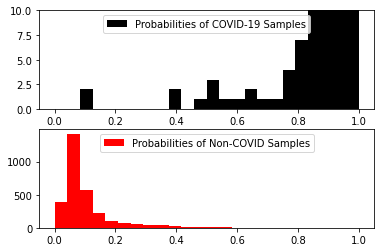

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_sh, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_sh, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/ShuffleNet/shufflenet_scores_histogram.png') #dpi = 200

## **SQUEEZENET OBSERVATION**

In [ ]:
squeezenet1 = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet1.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1,1))
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezenet1.parameters(), lr=3e-5)
squeezenet1.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/Squeezenet (A)/squeezenet1_0.pt'))

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


<All keys matched successfully>

__main__:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


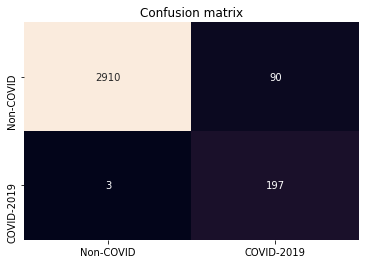

In [ ]:
squeezenet1.eval()
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob <= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob >= thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_sq= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_sq  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_sq= np.zeros([len(test_covid),1])   ##
non_prob_sq   = np.zeros([len(test_non),1])   ##

covid_prob_o_sq = np.zeros([len(test_covid),1])  ##
non_prob_o_sq   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_sq= image_loader(test_covid[i])
    model_output_sq= squeezenet1(cur_img_sq)
    cur_pred1_sq = model_output_sq.max(1, keepdim=True)[1]
    cur_prob_sq = sm(model_output_sq)
    covid_prob_sq[i,:]= cur_prob_sq.data.numpy()[0,0]
    covid_prob_o_sq[i,:]= cur_prob_sq.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_sq.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_sq= image_loader(test_non[j])
    model_output_sq= squeezenet1(cur_img_sq)
    cur_pred_sq = model_output_sq.max(1, keepdim=True)[1]  
    cur_prob_sq = sm(model_output_sq)
    non_prob_sq[j,:]= cur_prob_sq.data.numpy()[0,0]
    non_prob_o_sq[j,:]= cur_prob_sq.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_sq.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_sq, non_prob_o_sq, thresh)

covid_pred_sq = np.where( covid_prob_sq  >thresh, 0, 1)
non_pred_sq   = np.where( non_prob_sq  >thresh,   0, 1)

covid_list_sq= [int(covid_pred_sq[i]) for i in range(len(covid_pred_sq))]
covid_count_sq = [(x, covid_list_sq.count(x)) for x in set(covid_list_sq)]

non_list_sq= [int(non_pred_sq[i]) for i in range(len(non_pred_sq))]
non_count_sq = [(x, non_list_sq.count(x)) for x in set(non_list_sq)]

y_pred_list_sq= covid_list_sq+non_list_sq
y_test_list_sq= [1 for i in range(len(covid_list_sq))]+[0 for i in range(len(non_list_sq))]

y_pred_sq= np.asarray(y_pred_list_sq, dtype=np.int64) ##
y_test_sq= np.asarray(y_test_list_sq, dtype=np.int64) ##

cnf_matrix_sq = confusion_matrix(y_test_sq, y_pred_sq)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_sq = pd.DataFrame(cnf_matrix_sq, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_sq = sn.heatmap(df_cm_sq, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_sq.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Squeezenet (A)/sq_confusion_matrix.png') #dpi = 200

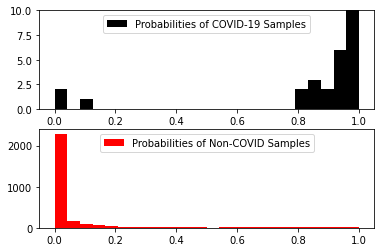

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_sq, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_sq, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/Squeezenet (A)/sq_scores_histogram.png') #dpi = 200

### **GoogleNet OBSERVATION**

In [ ]:
Googlenet = torchvision.models.googlenet(pretrained=True)
Googlenet.fc = torch.nn.Linear(in_features=1024, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Googlenet.parameters(), lr=3e-5)
Googlenet.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/LeNet (B)/LeNet.pt'))

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


<All keys matched successfully>

__main__:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid
025 Non-Covid predicted label:Non-Covid


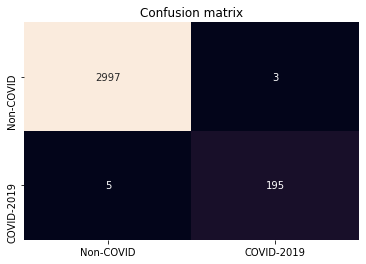

In [ ]:
Googlenet.eval()
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob <= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob >= thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_le= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_le  = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_le= np.zeros([len(test_covid),1])   ##
non_prob_le   = np.zeros([len(test_non),1])   ##

covid_prob_o_le = np.zeros([len(test_covid),1])  ##
non_prob_o_le   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_le= image_loader(test_covid[i])
    model_output_le= Googlenet(cur_img_le)
    cur_pred1_le = model_output_le.max(1, keepdim=True)[1]
    cur_prob_le = sm(model_output_le)
    covid_prob_le[i,:]= cur_prob_le.data.numpy()[0,0]
    covid_prob_o_le[i,:]= cur_prob_le.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_le.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_le= image_loader(test_non[j])
    model_output_le= Googlenet(cur_img_le)
    cur_pred_le = model_output_le.max(1, keepdim=True)[1]  
    cur_prob_le = sm(model_output_le)
    non_prob_le[j,:]= cur_prob_le.data.numpy()[0,0]
    non_prob_o_le[j,:]= cur_prob_le.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_le.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_le, non_prob_o_le, thresh)

covid_pred_le = np.where( covid_prob_le  >thresh, 0, 1)
non_pred_le   = np.where( non_prob_le  >thresh,   0, 1)

covid_list_le= [int(covid_pred_le[i]) for i in range(len(covid_pred_le))]
covid_count_le = [(x, covid_list_le.count(x)) for x in set(covid_list_le)]

non_list_le= [int(non_pred_le[i]) for i in range(len(non_pred_le))]
non_count_le = [(x, non_list_le.count(x)) for x in set(non_list_le)]

y_pred_list_le= covid_list_le+non_list_le
y_test_list_le= [1 for i in range(len(covid_list_le))]+[0 for i in range(len(non_list_le))]

y_pred_le= np.asarray(y_pred_list_le, dtype=np.int64) ##
y_test_le= np.asarray(y_test_list_le, dtype=np.int64) ##

cnf_matrix_le = confusion_matrix(y_test_le, y_pred_le)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_le = pd.DataFrame(cnf_matrix_le, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_le = sn.heatmap(df_cm_le, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_le.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/LeNet (B)/LeNet_confusion_matrix.png') #dpi = 200


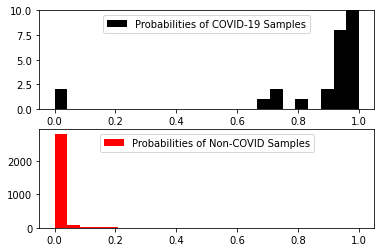

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_le, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_le, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/LeNet (B)/LeNet_scores_histogram.png') #dpi = 200

## **MOBILENET OBSERVATION**

In [ ]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=3e-5)
mobilenet.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/MobileNet/mobilenet.pt'))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


<All keys matched successfully>

__main__:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Covid
001 Covid predicted label:Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Covid
009 Covid predicted label:Covid
010 Covid predicted label:Covid
011 Covid predicted label:Covid
012 Covid predicted label:Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Covid
019 Covid predicted label:Covid
020 Covid predicted label:Covid
021 Covid predicted label:Covid
022 Covid predicted label:Covid
023 Covid predicted label:Covid
024 Covid predicted label:Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Covid
028 Covid predicted label:Covid
029 Covid predicted label:Covid
030 Covid predicted label:Covid
031 Covi

__main__:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:Non-Covid
001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Non-Covid


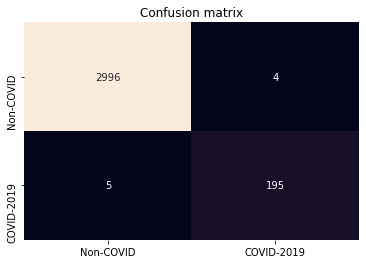

In [ ]:
mobilenet.eval()
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob <= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob >= thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_mo= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_mo = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_mo= np.zeros([len(test_covid),1])   ##
non_prob_mo   = np.zeros([len(test_non),1])   ##

covid_prob_o_mo = np.zeros([len(test_covid),1])  ##
non_prob_o_mo   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_mo= image_loader(test_covid[i])
    model_output_mo= mobilenet(cur_img_mo)
    cur_pred1_mo = model_output_mo.max(1, keepdim=True)[1]
    cur_prob_mo = sm(model_output_mo)
    covid_prob_mo[i,:]= cur_prob_mo.data.numpy()[0,0]
    covid_prob_o_mo[i,:]= cur_prob_mo.data.numpy()[0,1]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_mo.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_mo= image_loader(test_non[j])
    model_output_mo= mobilenet(cur_img_mo)
    cur_pred_mo = model_output_mo.max(1, keepdim=True)[1]  
    cur_prob_mo= sm(model_output_mo)
    non_prob_mo[j,:]= cur_prob_mo.data.numpy()[0,0]
    non_prob_o_mo[j,:]= cur_prob_mo.data.numpy()[0,1]
    print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_mo.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_mo, non_prob_o_mo, thresh)

covid_pred_mo = np.where( covid_prob_mo  >thresh, 0, 1)
non_pred_mo   = np.where( non_prob_mo  >thresh,   0, 1)

covid_list_mo= [int(covid_pred_mo[i]) for i in range(len(covid_pred_mo))]
covid_count_mo = [(x, covid_list_mo.count(x)) for x in set(covid_list_mo)]

non_list_mo= [int(non_pred_mo[i]) for i in range(len(non_pred_mo))]
non_count_mo = [(x, non_list_mo.count(x)) for x in set(non_list_mo)]

y_pred_list_mo= covid_list_mo+non_list_mo
y_test_list_mo= [1 for i in range(len(covid_list_mo))]+[0 for i in range(len(non_list_mo))]

y_pred_mo= np.asarray(y_pred_list_mo, dtype=np.int64) ##
y_test_mo= np.asarray(y_test_list_mo, dtype=np.int64) ##

cnf_matrix_mo = confusion_matrix(y_test_mo, y_pred_mo)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_mo = pd.DataFrame(cnf_matrix_mo, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_mo = sn.heatmap(df_cm_mo, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_mo.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/MobileNet/MobileNet_confusion_matrix.png') #dpi = 200


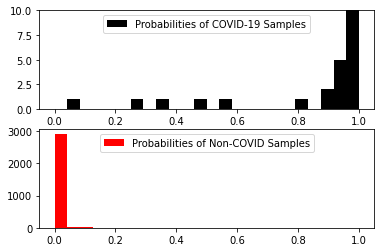

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_mo, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_mo, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/MobileNet/MobileNet_scores_histogram.png') #dpi = 200

## **MnasNET OBSERVATION**

In [ ]:
mnasnet = torchvision.models.mnasnet1_0(pretrained=True)
mnasnet.classifier[1] = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnasnet.parameters(), lr=3e-5)
mnasnet.load_state_dict(torch.load('/gdrive/My Drive/Research_Documents_completed/MnasNet/mnasnet.pt'))

<All keys matched successfully>

__main__:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:Non-Covid
001 Covid predicted label:Non-Covid
002 Covid predicted label:Covid
003 Covid predicted label:Covid
004 Covid predicted label:Covid
005 Covid predicted label:Covid
006 Covid predicted label:Covid
007 Covid predicted label:Covid
008 Covid predicted label:Non-Covid
009 Covid predicted label:Covid
010 Covid predicted label:Non-Covid
011 Covid predicted label:Covid
012 Covid predicted label:Non-Covid
013 Covid predicted label:Covid
014 Covid predicted label:Covid
015 Covid predicted label:Covid
016 Covid predicted label:Covid
017 Covid predicted label:Covid
018 Covid predicted label:Non-Covid
019 Covid predicted label:Covid
020 Covid predicted label:Non-Covid
021 Covid predicted label:Covid
022 Covid predicted label:Non-Covid
023 Covid predicted label:Non-Covid
024 Covid predicted label:Non-Covid
025 Covid predicted label:Covid
026 Covid predicted label:Covid
027 Covid predicted label:Non-Covid
028 Covid predicted label:Non-Covid
029 Covid predicted labe

__main__:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


001 Non-Covid predicted label:Non-Covid
002 Non-Covid predicted label:Non-Covid
003 Non-Covid predicted label:Non-Covid
004 Non-Covid predicted label:Non-Covid
005 Non-Covid predicted label:Non-Covid
006 Non-Covid predicted label:Non-Covid
007 Non-Covid predicted label:Non-Covid
008 Non-Covid predicted label:Non-Covid
009 Non-Covid predicted label:Non-Covid
010 Non-Covid predicted label:Non-Covid
011 Non-Covid predicted label:Non-Covid
012 Non-Covid predicted label:Non-Covid
013 Non-Covid predicted label:Non-Covid
014 Non-Covid predicted label:Non-Covid
015 Non-Covid predicted label:Non-Covid
016 Non-Covid predicted label:Non-Covid
017 Non-Covid predicted label:Non-Covid
018 Non-Covid predicted label:Non-Covid
019 Non-Covid predicted label:Non-Covid
020 Non-Covid predicted label:Non-Covid
021 Non-Covid predicted label:Non-Covid
022 Non-Covid predicted label:Non-Covid
023 Non-Covid predicted label:Non-Covid
024 Non-Covid predicted label:Covid
025 Non-Covid predicted label:Non-Covid
026 

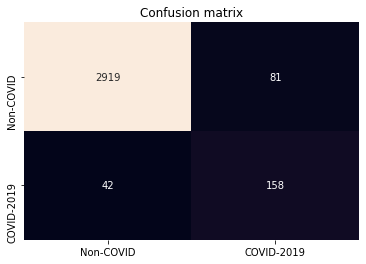

In [ ]:
mnasnet.eval()
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob <= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob >= thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred_mn= np.zeros([len(test_covid),1]).astype(int)  ##
non_pred_mn = np.zeros([len(test_non),1]).astype(int)  ##

covid_prob_mn= np.zeros([len(test_covid),1])   ##
non_prob_mn   = np.zeros([len(test_non),1])   ##

covid_prob_o_mn = np.zeros([len(test_covid),1])  ##
non_prob_o_mn   = np.zeros([len(test_non),1])  ##

for i in range(len(test_covid)):
    cur_img_mn= image_loader(test_covid[i])
    model_output_mn= mnasnet(cur_img_mn)
    cur_pred1_mn = model_output_mn.max(1, keepdim=True)[1]
    cur_prob_mn = sm(model_output_mn)
    covid_prob_mn[i,:]= cur_prob_mn.data.numpy()[0,0]
    covid_prob_o_mn[i,:]= cur_prob_mn.data.numpy()[0,1]
    #print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred1_mn.data.numpy())]) )
    
for j in range(len(test_non)):
    cur_img_mn= image_loader(test_non[j])
    model_output_mn= mnasnet(cur_img_mn)
    cur_pred_mn = model_output_mn.max(1, keepdim=True)[1]  
    cur_prob_mn= sm(model_output_mn)
    non_prob_mn[j,:]= cur_prob_mn.data.numpy()[0,0]
    non_prob_o_mn[j,:]= cur_prob_mn.data.numpy()[0,1]
    #print("%03d Non-Covid predicted label:%s" %(j, class_names[int(cur_pred_mn.data.numpy())]) )

thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec(covid_prob_o_mn, non_prob_o_mn, thresh)

covid_pred_mn = np.where( covid_prob_mn  >thresh, 0, 1)
non_pred_mn   = np.where( non_prob_mn  >thresh,   0, 1)

covid_list_mn= [int(covid_pred_mn[i]) for i in range(len(covid_pred_mn))]
covid_count_mn = [(x, covid_list_mn.count(x)) for x in set(covid_list_mn)]

non_list_mn= [int(non_pred_mn[i]) for i in range(len(non_pred_mn))]
non_count_mn = [(x, non_list_mn.count(x)) for x in set(non_list_mn)]

y_pred_list_mn= covid_list_mn+non_list_mn
y_test_list_mn= [1 for i in range(len(covid_list_mn))]+[0 for i in range(len(non_list_mn))]

y_pred_mn= np.asarray(y_pred_list_mn, dtype=np.int64) ##
y_test_mn= np.asarray(y_test_list_mn, dtype=np.int64) ##

cnf_matrix_mn = confusion_matrix(y_test_mn, y_pred_mn)  ##
np.set_printoptions(precision=2)   

# Plot normalized confusion matrix
df_cm_mn = pd.DataFrame(cnf_matrix_mn, index = [i for i in class_names], columns = [i for i in class_names])  ##


ax_mn = sn.heatmap(df_cm_mn, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019']) ##
ax_mn.set_title("Confusion matrix") ##
plt.savefig('/gdrive/My Drive/Research_Documents_completed/MnasNet/Mnasnet_confusion_matrix.png') #dpi = 200

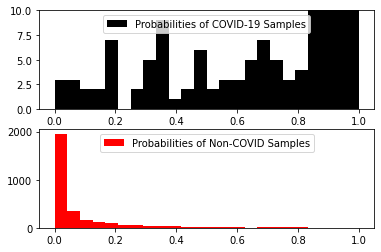

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob_o_mn, bins, color= 'black', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob_o_mn, bins, color= 'red', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/MnasNet/MnasNet_scores_histogram.png') #dpi = 200

## **ROC CURVE**


Total Time: 11518.03000831604


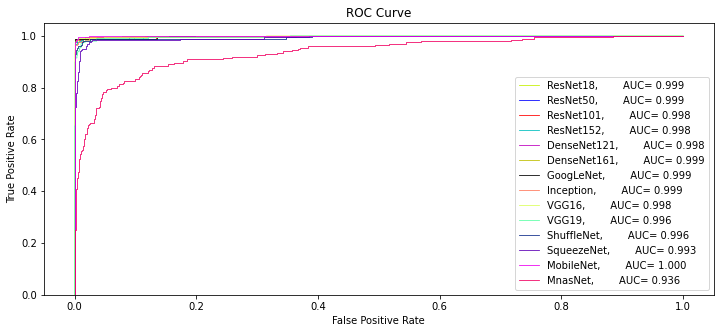

In [ ]:
############### ROC Curve and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


#r18
y_test_r18= [1 for i in range(len(covid_prob_o_r18))]+[0 for i in range(len(non_prob_o_r18))]
y_pred_r18= [covid_prob_o_r18[i] for i in range(len(covid_prob_o_r18))]+[non_prob_o_r18[i] for i in range(len(non_prob_o_r18))]
#r50
y_test_r50= [1 for i in range(len(covid_prob_o_r50))]+[0 for i in range(len(non_prob_o_r50))]
y_pred_r50= [covid_prob_o_r50[i] for i in range(len(covid_prob_o_r50))]+[non_prob_o_r50[i] for i in range(len(non_prob_o_r50))]
#r101
y_test_r101= [1 for i in range(len(covid_prob_o_r101))]+[0 for i in range(len(non_prob_o_r101))]
y_pred_r101= [covid_prob_o_r101[i] for i in range(len(covid_prob_o_r101))]+[non_prob_o_r101[i] for i in range(len(non_prob_o_r101))]
#r152
y_test_r152= [1 for i in range(len(covid_prob_o_r152))]+[0 for i in range(len(non_prob_o_r152))]
y_pred_r152= [covid_prob_o_r152[i] for i in range(len(covid_prob_o_r152))]+[non_prob_o_r152[i] for i in range(len(non_prob_o_r152))]
#d121
y_test_d121= [1 for i in range(len(covid_prob_o_d121))]+[0 for i in range(len(non_prob_o_d121))]
y_pred_d121= [covid_prob_o_d121[i] for i in range(len(covid_prob_o_d121))]+[non_prob_o_d121[i] for i in range(len(non_prob_o_d121))]
#d161
y_test_d161= [1 for i in range(len(covid_prob_o_d161))]+[0 for i in range(len(non_prob_o_d161))]
y_pred_d161= [covid_prob_o_d161[i] for i in range(len(covid_prob_o_d161))]+[non_prob_o_d161[i] for i in range(len(non_prob_o_d161))]
#le
y_test_le= [1 for i in range(len(covid_prob_o_le))]+[0 for i in range(len(non_prob_o_le))]
y_pred_le= [covid_prob_o_le[i] for i in range(len(covid_prob_o_le))]+[non_prob_o_le[i] for i in range(len(non_prob_o_le))]
#i
y_test_i= [1 for i in range(len(covid_prob_o_i))]+[0 for i in range(len(non_prob_o_i))]
y_pred_i= [covid_prob_o_i[i] for i in range(len(covid_prob_o_i))]+[non_prob_o_i[i] for i in range(len(non_prob_o_i))]
#v16
y_test_v16= [1 for i in range(len(covid_prob_o_v16))]+[0 for i in range(len(non_prob_o_v16))]
y_pred_v16= [covid_prob_o_v16[i] for i in range(len(covid_prob_o_v16))]+[non_prob_o_v16[i] for i in range(len(non_prob_o_v16))]
#v19
y_test_v19= [1 for i in range(len(covid_prob_o_v19))]+[0 for i in range(len(non_prob_o_v19))]
y_pred_v19= [covid_prob_o_v19[i] for i in range(len(covid_prob_o_v19))]+[non_prob_o_v19[i] for i in range(len(non_prob_o_v19))]
#sh
y_test_sh= [1 for i in range(len(covid_prob_o_sh))]+[0 for i in range(len(non_prob_o_sh))]
y_pred_sh= [covid_prob_o_sh[i] for i in range(len(covid_prob_o_sh))]+[non_prob_o_sh[i] for i in range(len(non_prob_o_sh))]
#sq
y_test_sq= [1 for i in range(len(covid_prob_o_sq))]+[0 for i in range(len(non_prob_o_sq))]
y_pred_sq= [covid_prob_o_sq[i] for i in range(len(covid_prob_o_sq))]+[non_prob_o_sq[i] for i in range(len(non_prob_o_sq))]
#mo
y_test_mo= [1 for i in range(len(covid_prob_o_mo))]+[0 for i in range(len(non_prob_o_mo))]
y_pred_mo= [covid_prob_o_mo[i] for i in range(len(covid_prob_o_mo))]+[non_prob_o_mo[i] for i in range(len(non_prob_o_mo))]
#mn
y_test_mn= [1 for i in range(len(covid_prob_o_mn))]+[0 for i in range(len(non_prob_o_mn))]
y_pred_mn= [covid_prob_o_mn[i] for i in range(len(covid_prob_o_mn))]+[non_prob_o_mn[i] for i in range(len(non_prob_o_mn))]

##############################
#r18
auc_r18 = roc_auc_score(y_test_r18, y_pred_r18)
ns_fpr_r18, ns_tpr_r18, _ = roc_curve(y_test_r18, y_pred_r18)
#r50
auc_r50 = roc_auc_score(y_test_r50, y_pred_r50)
ns_fpr_r50, ns_tpr_r50, _ = roc_curve(y_test_r50, y_pred_r50)
#r101
auc_r101 = roc_auc_score(y_test_r101, y_pred_r101)
ns_fpr_r101, ns_tpr_r101, _ = roc_curve(y_test_r101, y_pred_r101)
#r152
auc_r152 = roc_auc_score(y_test_r152, y_pred_r152)
ns_fpr_r152, ns_tpr_r152, _ = roc_curve(y_test_r152, y_pred_r152)
#d121
auc_d121 = roc_auc_score(y_test_d121, y_pred_d121)
ns_fpr_d121, ns_tpr_d121, _ = roc_curve(y_test_d121, y_pred_d121)
#d161
auc_d161 = roc_auc_score(y_test_d161, y_pred_d161)
ns_fpr_d161, ns_tpr_d161, _ = roc_curve(y_test_d161, y_pred_d161)
#le
auc_le = roc_auc_score(y_test_le, y_pred_le)
ns_fpr_le, ns_tpr_le, _ = roc_curve(y_test_le, y_pred_le)
#i
auc_i = roc_auc_score(y_test_i, y_pred_i)
ns_fpr_i, ns_tpr_i, _ = roc_curve(y_test_i, y_pred_i)
#v16
auc_v16 = roc_auc_score(y_test_v16, y_pred_v16)
ns_fpr_v16, ns_tpr_v16, _ = roc_curve(y_test_v16, y_pred_v16)
#v19
auc_v19 = roc_auc_score(y_test_v19, y_pred_v19)
ns_fpr_v19, ns_tpr_v19, _ = roc_curve(y_test_v19, y_pred_v19)
#sh
auc_sh = roc_auc_score(y_test_sh, y_pred_sh)
ns_fpr_sh, ns_tpr_sh, _ = roc_curve(y_test_sh, y_pred_sh)
#sq
auc_sq = roc_auc_score(y_test_sq, y_pred_sq)
ns_fpr_sq, ns_tpr_sq, _ = roc_curve(y_test_sq, y_pred_sq)
#mo
auc_mo = roc_auc_score(y_test_mo, y_pred_mo)
ns_fpr_mo, ns_tpr_mo, _ = roc_curve(y_test_mo, y_pred_mo)
#mn
auc_mn = roc_auc_score(y_test_mn, y_pred_mn)
ns_fpr_mn, ns_tpr_mn, _ = roc_curve(y_test_mn, y_pred_mn)
##########################
plt.figure(figsize=(12,5))
pyplot.plot(ns_fpr_r18, ns_tpr_r18,  color='#C5F001', linewidth=0.8,   label='ResNet18,        AUC= %.3f' %auc_r18)
pyplot.plot(ns_fpr_r50, ns_tpr_r50,  color='b', linewidth=0.8,   label='ResNet50,        AUC= %.3f' %auc_r50)
pyplot.plot(ns_fpr_r101, ns_tpr_r101,  color='r', linewidth=0.8,   label='ResNet101,        AUC= %.3f' %auc_r101)
pyplot.plot(ns_fpr_r152, ns_tpr_r152,  color='c', linewidth=0.8,   label='ResNet152,        AUC= %.3f' %auc_r152)
pyplot.plot(ns_fpr_d121, ns_tpr_d121,  color='m', linewidth=0.8,   label='DenseNet121,        AUC= %.3f' %auc_d121)
pyplot.plot(ns_fpr_d161, ns_tpr_d161,  color='y', linewidth=0.8,   label='DenseNet161,        AUC= %.3f' %auc_d161)
pyplot.plot(ns_fpr_le, ns_tpr_le,  color='k', linewidth=0.8,   label='GoogLeNet,        AUC= %.3f' %auc_le)
pyplot.plot(ns_fpr_i, ns_tpr_i,  color='#FF7A5D', linewidth=0.8,   label='Inception,        AUC= %.3f' %auc_i)
pyplot.plot(ns_fpr_v16, ns_tpr_v16,  color='#DBFF5D', linewidth=0.8,   label='VGG16,        AUC= %.3f' %auc_v16)
pyplot.plot(ns_fpr_v19, ns_tpr_v19,  color='#5DFFA6', linewidth=0.8,   label='VGG19,        AUC= %.3f' %auc_v19)
pyplot.plot(ns_fpr_sh, ns_tpr_sh,  color='#102D8A', linewidth=0.8,   label='ShuffleNet,        AUC= %.3f' %auc_sh)
pyplot.plot(ns_fpr_sq, ns_tpr_sq,  color='#5C00B6', linewidth=0.8,   label='SqueezeNet,        AUC= %.3f' %auc_sq)
pyplot.plot(ns_fpr_mo, ns_tpr_mo,  color='#ED01F0', linewidth=0.8,   label='MobileNet,        AUC= %.3f' %auc_mo)
pyplot.plot(ns_fpr_mn, ns_tpr_mn,  color='#F00162', linewidth=0.8,   label='MnasNet,        AUC= %.3f' %auc_mn)

pyplot.ylim([0,1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve")
# show the legend
pyplot.legend(loc='lower right')
plt.savefig('/gdrive/My Drive/Research_Documents_completed/ROC_covid19.png') #dpi = 200



end_time= time.time()
tot_time= end_time- start_time
print("\nTotal Time:", tot_time)